# CrowdTruth metrics 2.0 documentation

Let:

* $workers(u):$ all workers that annotate media unit $u$;
* $units(i):$ all input media units annotated by worker $i$;
* $WorkVec(i, u):$ annotations of worker $i$ on media unit $u$ as a binary vector;
* $MediaUnitVec(s) = \sum_{i \in workers(s)} WorkVec(i,s)$, where $s$ is an input media unit.

## Media Unit Quality Score (UQS)

The unit quality score $UQS(u)$ is computed as the average cosine similarity between all worker vectors for a given input media unit $u$, weighted by the worker quality ($WQS$) and annotation quality ($AQS$). The goal is to capture the degree of agreement in annotating the media unit. Through the weighted average, workers and annotations with lower quality will have less of an impact on the final score.

$$ UQS(u) = \frac{\sum_{i, j \in workers(u)} Wcos(WorkVec(i,u), WorkVec(j,u)) \; WQS(i) \; WQS(j)}{\sum_{i, j \in workers(u)} WQS(i) \; WQS(j)}, \; i \neq j.$$


### Weighted Cosine

To weigh the metrics with the annotation quality, we compute $Wcos$, the weighted version of the cosine similarity. This metric is only applicable to closed tasks, where annotation quality can be calculated across media units. For open-ended tasks, we consider annotation quality equal to 1 and calculate the regular cosine similarity.

$$ Wcos(vec_1, vec_2) = \frac{\sum_{a} vec_1(a) \; vec_2(a) \; AQS(a)}{\sqrt{(\sum_{a} vec_1^2(a) \; AQS(a)) \; (\sum_{a} vec_2^2(a) \; AQS(a))}} .$$ 


## Worker Quality Score (WQS)

The worker quality score $WQS(i)$ for a given worker $i$ is the product of 2 separate metrics - the worker-worker agreement $WWA(i)$ and the worker-media unit agreement $WUA(i)$.

$$ WQS(i) = WUA(i) \; WWA(i) .$$

### Worker-Media Unit Agreement

The worker-media unit agreement $WUA(i)$ is the average cosine distance between the annotations of a worker $i$ and all annotations for the media units they have worked on, weighted by the media unit and annotation quality. It calculates how much a worker disagrees with the crowd on a media unit basis. Through the weighted average, media units and anntation with lower quality will have less of an impact on the final score.

$$ WSA(i) = \frac{\sum_{u \in units(i)} Wcos(WorkVec(i,u), MediaUnitVec(u) - WorkVec(i, u)) \; UQS(u)}{\sum_{u \in units(i)} UQS(u)} .$$

### Worker-Worker Agreement

The worker-worker agreement $WWA(i)$ is the average cosine distance between the annotations of a worker $i$ and all other workers that have worked on the same media units as worker $i$, weighted by the worker and annotation qualities. The metric gives an indication as to whether there are consisently like-minded workers. This is useful for identifying communities of thought. Through the weighted average, workers and annotations with lower quality will have less of an impact on the final score of the given worker.

$$ WWA(i) = \frac{ \sum_{j \in workers(u \in units(i))} Wcos(WorkVec(i, u), WorkVec(j, u)) \; WQS(j) \; UQS(u) }{ \sum_{j \in workers(s \in units(i))} WQS(j) \; UQS(u) }, \; i \neq j .$$


## Annotation Quality Score (AQS)

The annotation quality score $AQS(a)$ calculates the agreement of selecting an annotation $a$, over all the media units it appears in. Therefore, it is only applicable to closed tasks, where the same annotation set is used for all input media units. It is based on $P_a(i | j)$, the probability that if a worker $j$ annotates $a$ in a media unit, worker $i$ will also annotate it. 

$$ P_a(i | j) = \frac{ \sum_{u \in units(i) \cap units(j) } UQS(u) \; WorkVec(i, s)(r) \; WorkVec(j, s)(r) }{ \sum_{u \in units(i) \cap units(j) } UQS(u) \; WorkVec(j, u)(r) } . $$

$AQS(a)$ is the weighted average of $P_a(i | j)$ for all possible pairs of workers. Through the weighted average, input media units and workers with lower quality will have less of an impact on the final score of the annotation.

$$ AQS(a) = \frac{ \sum_{i,j} WQS(i) \; WQS(j) \; P_a(i | j) }{ \sum_{i,j} WQS(i) \; WQS(j) }, i \neq j . $$


## Media Unit-Annotation Score (UAS)

The media unit - annotation score $UAS(u, a)$ calculates the likelihood that annotation $a$ is expressed in input media unit $u$. It is the ratio of the number of workers that picked annotation $u$ over all workers that annotated the unit, weighted by the worker quality.

$$ UAS(u, a) = \frac{ \sum_{i \in workers(u)} WorkVec(i,u)(a) \; WQS(i) }{ \sum_{i \in workers(u)} WQS(i) }. $$

# How to run the metrics


In [20]:
# Read data

import pandas as pd

pd.set_option('display.max_columns', None)
without_highlight_15workers_2p_filename = "AnalysisFiles/2P_WithoutHighlight_Article/2p_withoutHighlight_article_15workers.csv"
without_highlight_15workers_2p_dataset = pd.read_csv(without_highlight_15workers_2p_filename)

without_highlight_15workers_2p_dataset.head(5)

,_unit_id,_created_at,_id,_started_at,_tainted,_channel,_trust,_worker_id,_country,_region,_city,_ip,hiddeninput,relevance,bin,doc_len,document_body,document_id,document_title,hiddeninput_gold,index,rel,relevance_gold,topic,topic_description,topic_query
0,1444000758,11/9/2017 00:32:28,3011627616,11/9/2017 00:29:34,False,prodege,1,38202325,USA,ME,Caribou,98.13.82.121,NaN,not_relevant,1,196,<p>A public commission ruled today that Aum Sh...,1173003,Japan Puts Gas-Attack Sect Under Scrutiny,NaN,1,1,NaN,325,Describe a cult by name and identify the cult ...,Cult Lifestyles
1,1444000758,11/9/2017 02:01:01,3011982372,11/9/2017 02:00:45,False,neodev,1,41127744,USA,TX,Sugar Land,66.133.78.100,NaN,not_relevant,1,196,<p>A public commission ruled today that Aum Sh...,1173003,Japan Puts Gas-Attack Sect Under Scrutiny,NaN,1,1,NaN,325,Describe a cult by name and identify the cult ...,Cult Lifestyles
2,1444000759,11/8/2017 23:06:01,3011312937,11/8/2017 23:05:43,False,elite,1,43935069,USA,CA,San Jose,68.68.96.195,NaN,not_relevant,1,245,<p>ABC has signed a deal to develop a televisi...,920343,ABC Signs Film Deal On the Cult,NaN,2,1,NaN,325,Describe a cult by name and identify the cult ...,Cult Lifestyles
3,1444000759,11/9/2017 01:53:13,3011951679,11/9/2017 01:52:52,False,neodev,1,41127744,USA,TX,Sugar Land,66.133.78.100,NaN,not_relevant,1,245,<p>ABC has signed a deal to develop a televisi...,920343,ABC Signs Film Deal On the Cult,NaN,2,1,NaN,325,Describe a cult by name and identify the cult ...,Cult Lifestyles
4,1444000760,11/9/2017 00:35:42,3011639718,11/9/2017 00:34:52,False,prodege,1,38202325,USA,ME,Caribou,98.13.82.121,NaN,not_relevant,1,242,<p>Japan's peace of mind was shattered anew by...,757222,April 16-22; The Scent of Terror,NaN,3,1,NaN,325,Describe a cult by name and identify the cult ...,Cult Lifestyles


### Creating a class that inherits from `Configuration` lets us define how the input file will be processed:

* `inputColumns`: list of input columns from the .csv file, the input that the workers were shown
* `outputColumns`: list of output columns with the answers from the workers
* `processJudgments`: function that defines how the worker judgments wil be processed; default separator for judgments is ','

To build the annotation vector, we also need to specify whether this is an **open-ended** or **closed** task, using the `open_ended_task` variable.

* **open-ended task** means that the annotation space is not known, and workers can freely provide all the choices that apply (e.g. in sound tagging, the workers are provided with a text box to enter all tags they can think of)
* **closed task** means that the annotations that can occur in the data are already known, and the workers are asked to validate their existence (e.g. for medical relation extraction, the workers pick from a pre-defined multiple-choice set of relations)

If the task we are processing is **closed**, then we also need to provide the list of possible annotations in the `annotation_vector` variable.

In [21]:
import sys
sys.path.append('../')

from defaultconfig import Configuration

class NYTRelevanceAssessmentValidationConfig(Configuration):
    inputColumns = ["index", "bin", "doc_len", "document_id", "document_body", "document_title", "rel", 
                    "topic", "topic_description", "topic_query"]
    outputColumns = ["relevance"]
    
    annotation_separator = ','
    
    # processing of a closed task
    open_ended_task = False
    annotation_vector = [
        "relevant", "not_relevant"
    ]
    
    def processJudgments(self, judgments):
        # change default separator to whitespace to make it work with our file
        for col in self.outputColumns:
            judgments[col] = judgments[col].apply(lambda x: x.replace(' ',','))
        return judgments

config = NYTRelevanceAssessmentValidationConfig()

### Pre-process the data and create the annotation vectors


In [22]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [23]:
from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=without_highlight_15workers_2p_filename,
    config=config
)

### Run the metrics

In [24]:
# run the metrics
from models import Metrics
results_without_highlight_15workers = Metrics.run(pre_processed_results, config)

INFO:root:1 iterations; max d= 0.743892898234 ; wqs d= 0.488820335959; sqs d= 0.325079365079; rqs d= 0.408968776212
INFO:root:2 iterations; max d= 0.127275329553 ; wqs d= 0.0623260014015; sqs d= 0.0350900587689; rqs d= 0.0463513563944
INFO:root:3 iterations; max d= 0.0267369254685 ; wqs d= 0.0101638016378; sqs d= 0.00340898359856; rqs d= 0.00704447071036
INFO:root:4 iterations; max d= 0.0100822951985 ; wqs d= 0.00324383082293; sqs d= 0.00292296620572; rqs d= 0.00435232369242
INFO:root:5 iterations; max d= 0.00427416806634 ; wqs d= 0.00157266370672; sqs d= 0.000707938241059; rqs d= 0.00146319797663
INFO:root:6 iterations; max d= 0.00180261383784 ; wqs d= 0.000610382367752; sqs d= 0.000415051511052; rqs d= 0.000701696631108
INFO:root:7 iterations; max d= 0.000765789369488 ; wqs d= 0.000273644784095; sqs d= 0.000141027954318; rqs d= 0.000274773921368


In [25]:
results_without_highlight_15workers["units"].head(5)

,duration,input.bin,input.doc_len,input.document_body,input.document_id,input.document_title,input.index,input.rel,input.topic,input.topic_description,input.topic_query,job,output.relevance,output.relevance.annotations,output.relevance.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
unit,,,,,,,,,,,,,,,,,,,,
1444000758,40.066667,1,196,<p>A public commission ruled today that Aum Sh...,1173003,Japan Puts Gas-Attack Sect Under Scrutiny,1,1,325,Describe a cult by name and identify the cult ...,Cult Lifestyles,AnalysisFiles/2P_WithoutHighlight_Article/2p_w...,"{u'not_relevant': 2, u'relevant': 13}",15,2,15,0.804459,"{u'not_relevant': 0.101161348012, u'relevant':...",0.752381,"{u'not_relevant': 0.133333333333, u'relevant':..."
1444000759,39.866667,1,245,<p>ABC has signed a deal to develop a televisi...,920343,ABC Signs Film Deal On the Cult,2,1,325,Describe a cult by name and identify the cult ...,Cult Lifestyles,AnalysisFiles/2P_WithoutHighlight_Article/2p_w...,"{u'not_relevant': 2, u'relevant': 13}",15,2,15,0.791826,"{u'not_relevant': 0.108514946118, u'relevant':...",0.752381,"{u'not_relevant': 0.133333333333, u'relevant':..."
1444000760,28.800000,1,242,<p>Japan's peace of mind was shattered anew by...,757222,April 16-22; The Scent of Terror,3,1,325,Describe a cult by name and identify the cult ...,Cult Lifestyles,AnalysisFiles/2P_WithoutHighlight_Article/2p_w...,"{u'not_relevant': 4, u'relevant': 11}",15,2,15,0.625324,"{u'not_relevant': 0.224397878816, u'relevant':...",0.580952,"{u'not_relevant': 0.266666666667, u'relevant':..."
1444000761,46.266667,1,237,"<p>USA Networks Interactive, creator of the sc...",1209320,SCIFI.com in Venture With Filmmaker,4,0,325,Describe a cult by name and identify the cult ...,Cult Lifestyles,AnalysisFiles/2P_WithoutHighlight_Article/2p_w...,"{u'not_relevant': 8, u'relevant': 7}",15,2,15,0.462794,"{u'not_relevant': 0.471553726004, u'relevant':...",0.466667,"{u'not_relevant': 0.533333333333, u'relevant':..."
1444000762,46.666667,1,140,<p>To the Editor:</p> <p>There is ample eviden...,1667028,Vital at 50: Does Lifestyle Matter?,5,0,325,Describe a cult by name and identify the cult ...,Cult Lifestyles,AnalysisFiles/2P_WithoutHighlight_Article/2p_w...,"{u'not_relevant': 6, u'relevant': 9}",15,2,15,0.545158,"{u'not_relevant': 0.302754989054, u'relevant':...",0.485714,"{u'not_relevant': 0.4, u'relevant': 0.6}"


### Plot the unit quality score (UQS) at the beginning of the process and at the end

Text(0,0.5,u'# Units')

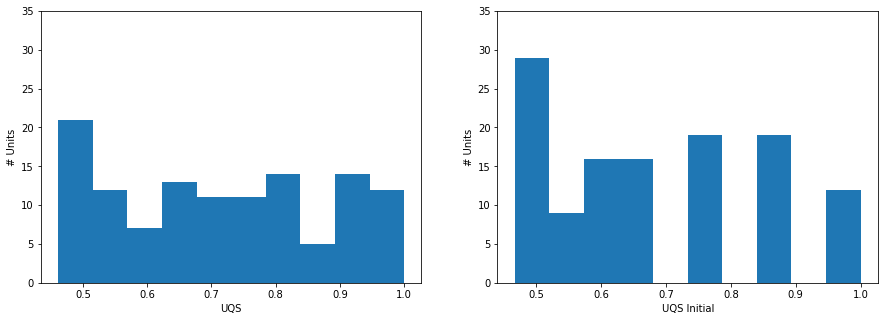

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(results_without_highlight_15workers["units"]["uqs"])
plt.ylim(0, 35)
plt.xlabel("UQS")
plt.ylabel("# Units")

plt.subplot(1, 2, 2)
plt.hist(results_without_highlight_15workers["units"]["uqs_initial"])
plt.ylim(0, 35)
plt.xlabel("UQS Initial")
plt.ylabel("# Units")

### Plot the change in the unit quality score (UQS) (beginning of the process - end of the process)

Text(0,0.5,u'Change in clarity')

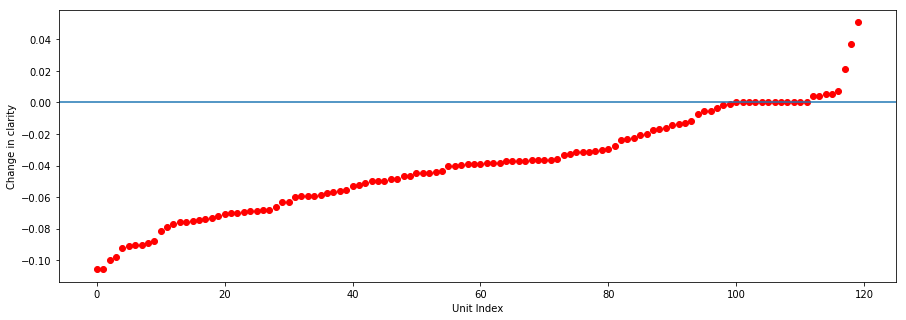

In [27]:
import numpy as np

difference = results_without_highlight_15workers["units"]["uqs_initial"] - results_without_highlight_15workers["units"]["uqs"]
difference = np.sort(difference)
plt.plot(np.arange(results_without_highlight_15workers["units"].shape[0]), difference, 'ro')
plt.axhline(y=0)
plt.xlabel("Unit Index")
plt.ylabel("Change in clarity")

In [28]:
sortUQS = results_without_highlight_15workers["units"].sort(['uqs'], ascending=[1])

/Users/oanainel/anaconda/envs/CrowdTruth2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


Text(0.5,0,u'Sentence Index')

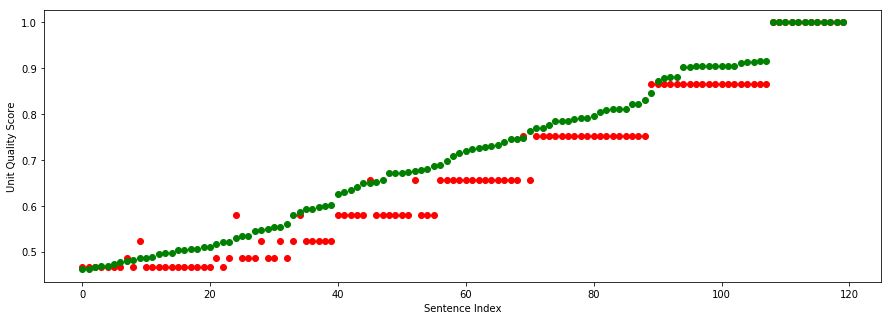

In [29]:
import numpy as np

plt.rcParams['figure.figsize'] = 15, 5

plt.plot(np.arange(sortUQS.shape[0]), sortUQS["uqs_initial"], 'ro', lw = 1, label = "Initial UQS")
plt.plot(np.arange(sortUQS.shape[0]), sortUQS["uqs"], 'go', lw = 1, label = "Final UQS")

plt.ylabel('Unit Quality Score')
plt.xlabel('Sentence Index')

### Plot the worker quality score (WQS) at the beginning of the process and at the end

#### Print the results for the workers in our dataset

In [30]:
results_without_highlight_15workers["workers"].head(10)

,duration,output.relevance.count,job,judgment,unit,wqs,wqs_initial
worker,,,,,,,
1924522,15.857143,1,1,7,7,0.659471,0.599884
3587109,27.384615,1,1,13,13,0.618420,0.550002
6377879,51.030000,1,1,100,100,0.469648,0.437929
11131207,43.870000,1,1,100,100,0.386658,0.368457
11314968,178.692308,1,1,13,13,0.581014,0.533296
13581319,17.000000,1,1,12,12,0.636856,0.583221
15577915,28.636364,1,1,22,22,0.490570,0.466935
17122301,25.000000,1,1,1,1,0.269962,0.353553
18672993,444.800000,1,1,10,10,0.667406,0.597893


Text(0,0.5,u'# Workers')

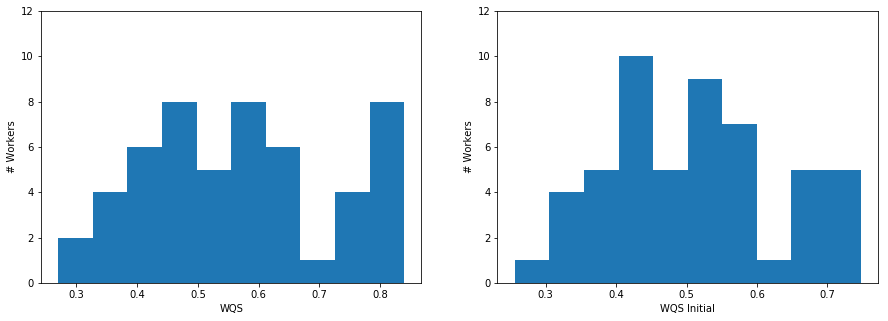

In [31]:
plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(results_without_highlight_15workers["workers"]["wqs"])
plt.ylim(0, 12)
plt.xlabel("WQS")
plt.ylabel("# Workers")

plt.subplot(1, 2, 2)
plt.hist(results_without_highlight_15workers["workers"]["wqs_initial"])
plt.ylim(0, 12)
plt.xlabel("WQS Initial")
plt.ylabel("# Workers")

### Plot the change in worker qualtity score (WQS) at the beginning of the process and at the end

In [32]:
sortWQS = results_without_highlight_15workers["workers"].sort(['wqs'], ascending=[1])

/Users/oanainel/anaconda/envs/CrowdTruth2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


Text(0.5,0,u'Worker Index')

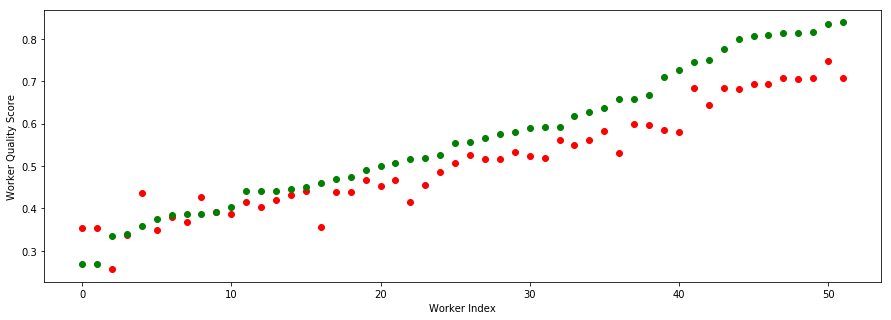

In [33]:
plt.rcParams['figure.figsize'] = 15, 5

plt.plot(np.arange(sortWQS.shape[0]), sortWQS["wqs_initial"], 'ro', lw = 1, label = "Initial UQS")
plt.plot(np.arange(sortWQS.shape[0]), sortWQS["wqs"], 'go', lw = 1, label = "Final UQS")

plt.ylabel('Worker Quality Score')
plt.xlabel('Worker Index')
#plt.legend(loc=9, bbox_to_anchor=(0.5, 1.2), ncol=3, prop={'size':12})

### Show the annotation quality score (AQS) at the beginning of the process and at the end


In [34]:
results_without_highlight_15workers["annotations"]

,output.relevance,aqs,aqs_initial
relevant,1800,0.800302,0.734090
not_relevant,1800,0.393809,0.447973


## Comparison with revised ground truth

In [35]:
gt = pd.read_csv("ground_truth_annotation.csv")

results_without_highlight_15workers["units"]["reviewers_rel"] = pd.Series(np.random.randn(len(results_without_highlight_15workers["units"].index)), index=results_without_highlight_15workers["units"].index)
results_without_highlight_15workers["units"]["reviewers_rel_merged"] = pd.Series(np.random.randn(len(results_without_highlight_15workers["units"].index)), index=results_without_highlight_15workers["units"].index)
results_without_highlight_15workers["units"]["rel_merged"] = pd.Series(np.random.randn(len(results_without_highlight_15workers["units"].index)), index=results_without_highlight_15workers["units"].index)

for i in range(0, len(results_without_highlight_15workers["units"].index)):
    for j in range(0, len(gt.index)):
        if (results_without_highlight_15workers["units"]["input.topic"].iloc[i] == gt["topic"].iloc[j]) and (results_without_highlight_15workers["units"]["input.document_id"].iloc[i] == gt["document_id"].iloc[j]):
            results_without_highlight_15workers["units"]["reviewers_rel"].iloc[i] = gt["reviewers_rel"].iloc[j]
            results_without_highlight_15workers["units"]["reviewers_rel_merged"].iloc[i] = gt["reviewers_rel_merged"].iloc[j]
            results_without_highlight_15workers["units"]["rel_merged"].iloc[i] = gt["nist_rel_merged"].iloc[j]

In [36]:
results_without_highlight_15workers["units"]["relevance_score"] = pd.Series(np.random.randn(len(results_without_highlight_15workers["units"].index)), index=results_without_highlight_15workers["units"].index)

for i in range(0, len(results_without_highlight_15workers["units"].index)):
    results_without_highlight_15workers["units"]["relevance_score"].iloc[i] = results_without_highlight_15workers["units"]['unit_annotation_score'].iloc[i]["relevant"]

In [37]:
import help_functions as func
withouthighlight_15workers_F1_notrelevant_merged = func.compute_F1_score_not_relevant(results_without_highlight_15workers["units"])
withouthighlight_15workers_F1_relevant_merged = func.compute_F1_score_relevant(results_without_highlight_15workers["units"])

In [38]:
withouthighlight_15workers_F1_notrelevant_merged

array([[ 0.01      ,  0.        ],
       [ 0.02      ,  0.        ],
       [ 0.03      ,  0.        ],
       [ 0.04      ,  0.        ],
       [ 0.05      ,  0.        ],
       [ 0.06      ,  0.        ],
       [ 0.07      ,  0.        ],
       [ 0.08      ,  0.        ],
       [ 0.09      ,  0.        ],
       [ 0.1       ,  0.        ],
       [ 0.11      ,  0.        ],
       [ 0.12      ,  0.        ],
       [ 0.13      ,  0.        ],
       [ 0.14      ,  0.        ],
       [ 0.15      ,  0.        ],
       [ 0.16      ,  0.        ],
       [ 0.17      ,  0.        ],
       [ 0.18      ,  0.        ],
       [ 0.19      ,  0.        ],
       [ 0.2       ,  0.        ],
       [ 0.21      ,  0.03703704],
       [ 0.22      ,  0.03703704],
       [ 0.23      ,  0.03703704],
       [ 0.24      ,  0.03703704],
       [ 0.25      ,  0.03703704],
       [ 0.26      ,  0.03703704],
       [ 0.27      ,  0.07272727],
       [ 0.28      ,  0.07272727],
       [ 0.29      ,

In [39]:
withouthighlight_15workers_F1_relevant_merged

array([[ 0.01      ,  0.71657754],
       [ 0.02      ,  0.71657754],
       [ 0.03      ,  0.71657754],
       [ 0.04      ,  0.71657754],
       [ 0.05      ,  0.71657754],
       [ 0.06      ,  0.71657754],
       [ 0.07      ,  0.71657754],
       [ 0.08      ,  0.71657754],
       [ 0.09      ,  0.71657754],
       [ 0.1       ,  0.71657754],
       [ 0.11      ,  0.71657754],
       [ 0.12      ,  0.71657754],
       [ 0.13      ,  0.71657754],
       [ 0.14      ,  0.71657754],
       [ 0.15      ,  0.71657754],
       [ 0.16      ,  0.71657754],
       [ 0.17      ,  0.71657754],
       [ 0.18      ,  0.71657754],
       [ 0.19      ,  0.71657754],
       [ 0.2       ,  0.71657754],
       [ 0.21      ,  0.72043011],
       [ 0.22      ,  0.72043011],
       [ 0.23      ,  0.72043011],
       [ 0.24      ,  0.72043011],
       [ 0.25      ,  0.72043011],
       [ 0.26      ,  0.72043011],
       [ 0.27      ,  0.72432432],
       [ 0.28      ,  0.72432432],
       [ 0.29      ,

In [40]:
withouthighlight_expertsF1_notrelevant_merged_newGT = func.compute_F1_score_experts_merged(results_without_highlight_15workers["units"],0)
withouthighlight_expertsF1_relevant_merged_newGT = func.compute_F1_score_experts_merged(results_without_highlight_15workers["units"],1)

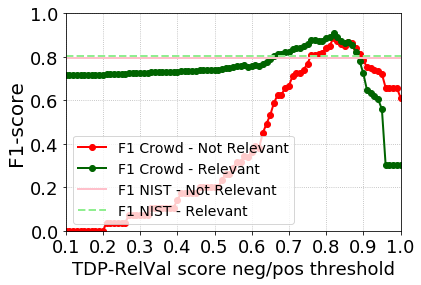

In [41]:
plt.rcParams['figure.figsize'] = 6, 4
plt.plot(withouthighlight_15workers_F1_notrelevant_merged[:,0], withouthighlight_15workers_F1_notrelevant_merged[:,1], 'bo-', color = 'red', lw = 2, label = "F1 Crowd - Not Relevant")
plt.plot(withouthighlight_15workers_F1_relevant_merged[:,0], withouthighlight_15workers_F1_relevant_merged[:,1], 'bo-', color = 'darkgreen', lw = 2, label = "F1 Crowd - Relevant")

plt.axhline(y = withouthighlight_expertsF1_notrelevant_merged_newGT, ls = '-', color = 'pink', lw = 2, label = "F1 NIST - Not Relevant")
plt.axhline(y = withouthighlight_expertsF1_relevant_merged_newGT, ls = '--', color = 'lightgreen', lw = 2, label = "F1 NIST - Relevant")
plt.xlim(0.1,1.0)
plt.xlabel("TDP-RelVal score neg/pos threshold", fontsize=18)
plt.ylabel("F1-score", fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0.0,1.0)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
leg = plt.legend(fontsize=14, loc="lower left")
leg.get_frame().set_alpha(0.8)
plt.grid(ls=':')
#plt.title("Without Highlight, Relations Not Merged, 3-point scale")
plt.savefig("Plots/2p_withoutHighlight_F1_merged_eval_reviewers.pdf", bbox_inches='tight', dpi=1000)

In [42]:
results_without_highlight_15workers["units"]["relevance_score"] = pd.Series(np.random.randn(len(results_without_highlight_15workers["units"].index)), index=results_without_highlight_15workers["units"].index)

for i in range(0, len(results_without_highlight_15workers["units"].index)):
    results_without_highlight_15workers["units"]["relevance_score"].iloc[i] = results_without_highlight_15workers["units"]['unit_annotation_score'].iloc[i]["relevant"]

In [43]:
results_without_highlight_15workers["units"].to_csv("ResultFiles/2P_WithoutHighlight_Article/units_withoutHighlight_15workers_2p.csv", index=False)